# Time Series

## Using Time Series Modeling to create better predictions for 2020 and 2021

**Objective**: To use time series analysis and modeling to create a better set of predictions for what the mulfifamily housing market will look like in 2021. 

In order to do that, we need the followings steps:

1. Use time series to model values for:
    * `total_high_density_units`
    * `total_high_density_blgs`
    * `total_high_density_value`
    * `ie`
    
2. Once we have predictions, we will use `total_high_density_units` and `total_high_density_blgs` to calculate new `avg_units_per_blg`

3. We will use `avg_units_per_blg` and `ei` to predict what the clusters would look like for our new predictions. We will need to scale these two values using a Power Transformer

4. Once all this is done, we can bring in our KNN and create predictions on the new dataset.

In [153]:
# import data science libraries
import numpy as np
import pandas as pd

import re

import os.path
from os import path

from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.cluster import KMeans

import wrangle as wr
import preprocessing_permits as pr
import explore as ex
import model as mo

import warnings
warnings.filterwarnings("ignore")

import time_series_modeling

from math import sqrt

from sklearn import metrics
from sklearn.metrics import mean_squared_error
import sklearn

# FB Prophet
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import plot_forecast_component

In [109]:
features_for_modeling = ["ei_x", "avg_units_per_bldg_x", "cluster", "total_high_density_bldgs", "total_high_density_value"]
label_feature = "should_enter"

In [110]:
features_for_modeling = ["ei_x", "total_high_density_units", "total_high_density_bldgs", "total_high_density_value"]

In [111]:
df, kmeans = mo.prep_prediction_data()

In [112]:
df["city_state"] = df.city + "_" + df.state

In [113]:
unique_city_states = df.city_state.unique()

In [114]:
modeling_df = df[df.city_state == unique_city_states[5]]

In [115]:
df

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg_x,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei_x,city_state,cluster,avg_units_per_bldg_y,ei_y
0,Albany,NY,1998,47.0,1038.0,54232000.0,22.085106,1.153872e+06,52246.628131,0.566667,1.442353,2.034637,2.529787e+10,0.231085,2.465010,Albany_NY,1,0.023700,1.710680
1,Albany,NY,1999,39.0,515.0,24484000.0,13.205128,6.277949e+05,47541.747573,-0.170213,-0.503854,-0.548532,2.609590e+10,0.031545,0.437662,Albany_NY,0,0.134099,-0.882271
2,Albany,NY,2000,25.0,346.0,16130000.0,13.840000,6.452000e+05,46618.497110,-0.358974,-0.328155,-0.341202,2.742204e+10,0.050818,0.626938,Albany_NY,0,0.134099,-0.882271
3,Albany,NY,2001,56.0,502.0,24536000.0,8.964286,4.381429e+05,48876.494024,1.240000,0.450867,0.521141,2.913103e+10,0.062322,1.431902,Albany_NY,5,-0.995691,0.127961
4,Albany,NY,2002,47.0,475.0,29634000.0,10.106383,6.305106e+05,62387.368421,-0.160714,-0.053785,0.207776,3.169504e+10,0.088016,1.110072,Albany_NY,5,-0.995691,0.127961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2855,York,PA,2015,3.0,53.0,3185000.0,17.666667,1.061667e+06,60094.339623,-0.666667,-0.320513,-0.449724,5.200240e+10,0.313639,0.418895,York_PA,0,0.134099,-0.882271
2856,York,PA,2016,3.0,34.0,1566000.0,11.333333,5.220000e+05,46058.823529,0.000000,-0.358491,-0.508320,4.928300e+10,-0.052294,0.518810,York_PA,0,0.134099,-0.882271
2857,York,PA,2017,15.0,83.0,10204000.0,5.533333,6.802667e+05,122939.759036,4.000000,1.441176,5.515964,5.158824e+10,0.046775,6.224796,York_PA,5,-0.995691,0.127961
2858,York,PA,2018,2.0,26.0,2160000.0,13.000000,1.080000e+06,83076.923077,-0.866667,-0.686747,-0.788318,5.336251e+10,0.034393,0.204643,York_PA,4,-1.407036,-1.636162


## Split Data 
For practical sense - we will start by modeling only one feature. 

In [116]:
modeling_df = modeling_df[["year", "city_state", "ei_x"]]

In [117]:
modeling_df.year = pd.to_datetime(modeling_df.year, format = '%Y')

In [118]:
modeling_df = modeling_df.set_index("year")

In [156]:
# Split our data

train = modeling_df[:"2015"]
validate = modeling_df["2016":"2017"]
test = modeling_df["2018":]

In [12]:
def plot_splits(train, validate, test, target_variable):
    sns.lineplot(data=train, x=train.index, y= target_variable)
    sns.lineplot(data=validate, x=validate.index, y= target_variable)
    sns.lineplot(data=test, x=test.index, y= target_variable)

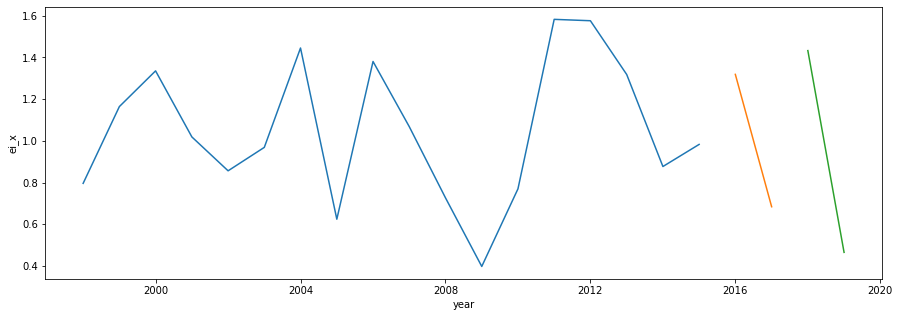

In [13]:
plt.figure(figsize=(15,5))
plot_splits(train, validate, test, target_variable="ei_x")

In [120]:
train

,city_state,ei_x
year,,
1998-01-01,Atlanta_GA,0.795989
1999-01-01,Atlanta_GA,1.164195
2000-01-01,Atlanta_GA,1.335546
2001-01-01,Atlanta_GA,1.018631
2002-01-01,Atlanta_GA,0.856185
2003-01-01,Atlanta_GA,0.968583
2004-01-01,Atlanta_GA,1.445231
2005-01-01,Atlanta_GA,0.623998
2006-01-01,Atlanta_GA,1.380533


## Modeling

In [15]:
target_variable = "ei_x"

In [16]:
predictions = time_series_modeling.create_predictions_df(train, validate, target_variable)

In [17]:
predictions = time_series_modeling.run_all_models(train, validate, target_variable, rolling_period = [1, 2, 3])

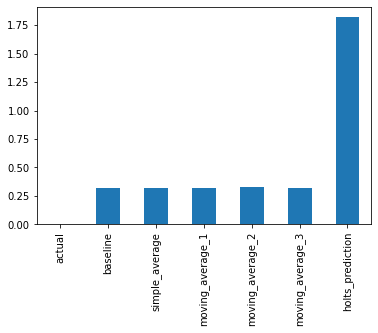

In [18]:
# Evaluate

time_series_modeling.plot_rmse(predictions)

In [62]:
rmse = predictions.apply(lambda col: sqrt(sklearn.metrics.mean_squared_error(predictions.actual, col)))

In [63]:
rmse = pd.DataFrame(rmse, columns=["austin"])

In [54]:
results = pd.DataFrame()

In [66]:
results = pd.concat([rmse, results], axis = 1)

In [67]:
results

,austin,austin,austin,new_york
actual,0.000000,0.000000,NaN,0.000000
baseline,4.105206,4.105206,NaN,4.105206
simple_average,3.579520,3.579520,NaN,3.579520
moving_average_1,4.105206,4.105206,NaN,4.105206
moving_average_2,4.012748,4.012748,NaN,4.012748
moving_average_3,3.901893,3.901893,NaN,3.901893
holts_prediction,2.816334,2.816334,NaN,2.816334


In [21]:
predictions

,actual,baseline,simple_average,moving_average_1,moving_average_2,moving_average_3,holts_prediction
year,,,,,,,
2016-01-01,1.318698,0.98,1.05,0.98,0.93,1.06,2.739135
2017-01-01,0.683854,0.98,1.05,0.98,0.93,1.06,2.827545


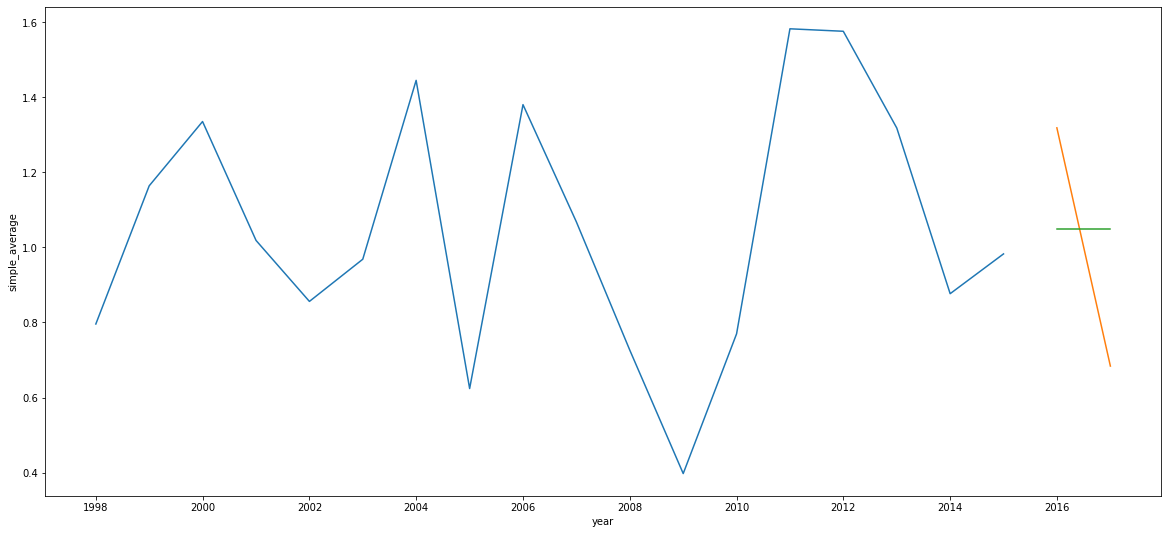

In [22]:
time_series_modeling.plot_prediction("simple_average", "ei_x", train, validate, predictions)

## Time Series Modeling Looking at `Evolution Index`

In [68]:
# Going to need to create a loop, and create an average rmse score to see which one would be best

results = pd.DataFrame()
updates = 0
for i in unique_city_states:
    # read data and create dataframe
    df, kmeans = mo.prep_prediction_data()
    df["city_state"] = df.city + "_" + df.state
    modeling_df = df[df.city_state == i]
    
    # Create new dataframes
    modeling_df = modeling_df[["year", "city_state", "ei_x"]]
    modeling_df.year = pd.to_datetime(modeling_df.year, format = '%Y')
    modeling_df = modeling_df.set_index("year")
    # Split our data
    train = modeling_df[:"2015"]
    validate = modeling_df["2016":"2017"]
    test = modeling_df["2018":]
    # Model
    target_variable = "ei_x"
    predictions = time_series_modeling.run_all_models(train, validate, target_variable, rolling_period = [1, 2, 3])
    # Evaluate
    rmse = predictions.apply(lambda col: sqrt(sklearn.metrics.mean_squared_error(predictions.actual, col)))
    rmse = pd.DataFrame(rmse, columns=[i])
    
    results = pd.concat([rmse, results], axis = 1)

In [85]:
results

,York_PA,Worcester_MA,Wilmington_NC,Washington_DC,Tuscaloosa_AL,Tulsa_OK,Tucson_AZ,Trenton_NJ,Toledo_OH,Tampa_FL,...,Birmingham_AL,Bellingham_WA,Baltimore_MD,Austin_TX,Atlanta_GA,Appleton_WI,Anchorage_AK,Allentown_PA,Albuquerque_NM,Albany_NY
actual,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
baseline,4.105206,1.652011,1.774735,0.665929,2.864555,1.058136,43.475518,0.692435,2.467644,0.310977,...,0.776304,0.111639,0.539647,0.241683,0.318135,0.437947,0.590287,0.431230,1.564790,1.715999
simple_average,3.579520,0.959803,1.386457,0.356760,2.089662,0.910135,42.671698,2.836515,1.536105,0.261566,...,1.359185,0.914284,0.555055,0.201730,0.321140,0.612019,0.378168,0.838189,1.223848,0.758062
moving_average_1,4.105206,1.652011,1.774735,0.665929,2.864555,1.058136,43.475518,0.692435,2.467644,0.310977,...,0.776304,0.111639,0.539647,0.241683,0.318135,0.437947,0.590287,0.431230,1.564790,1.715999
moving_average_2,4.012748,0.582284,1.774735,0.449141,2.514852,0.714645,43.229221,0.494694,1.425346,0.288324,...,0.776304,0.109584,0.393376,0.049735,0.325326,0.474169,1.856981,1.260292,1.692168,1.091411
moving_average_3,3.901893,0.208312,1.693530,0.492794,2.357262,0.722334,43.124104,0.419178,1.632122,0.232357,...,0.629006,0.607373,0.430209,0.049735,0.322809,0.386439,1.441572,0.873376,1.545853,0.699900
holts_prediction,2.816334,9.841038,1.287227,0.812374,2.606097,25.702893,40.307259,27.274994,3.490871,0.241103,...,0.904828,44.515346,0.359949,4.649640,1.818386,1.717449,4.812378,5.125046,3.693628,8.603365


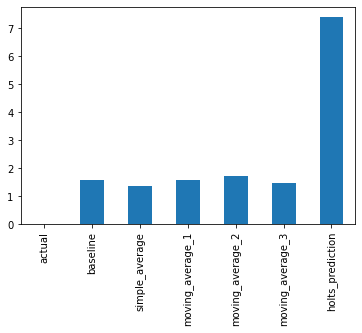

In [86]:
results.T.describe().loc["mean"].plot.bar()

We can see that - when it comes to predicting evolution index, the simple average actually peforms best.

## Time Series Modeling Looking at `total_high_density_value`

In [90]:
# Going to need to create a loop, and create an average rmse score to see which one would be best

results = pd.DataFrame()
updates = 0
for i in unique_city_states:
    # read data and create dataframe
    df, kmeans = mo.prep_prediction_data()
    df["city_state"] = df.city + "_" + df.state
    modeling_df = df[df.city_state == i]
    
    # Create new dataframes
    modeling_df = modeling_df[["year", "city_state", "total_high_density_value"]]
    modeling_df.year = pd.to_datetime(modeling_df.year, format = '%Y')
    modeling_df = modeling_df.set_index("year")
    # Split our data
    train = modeling_df[:"2015"]
    validate = modeling_df["2016":"2017"]
    test = modeling_df["2018":]
    # Model
    target_variable = "total_high_density_value"
    predictions = time_series_modeling.run_all_models(train, validate, target_variable, rolling_period = [1, 2, 3])
    # Evaluate
    rmse = predictions.apply(lambda col: sqrt(sklearn.metrics.mean_squared_error(predictions.actual, col)))
    rmse = pd.DataFrame(rmse, columns=[i])
    
    results = pd.concat([rmse, results], axis = 1)
    
results

,York_PA,Worcester_MA,Wilmington_NC,Washington_DC,Tuscaloosa_AL,Tulsa_OK,Tucson_AZ,Trenton_NJ,Toledo_OH,Tampa_FL,...,Birmingham_AL,Bellingham_WA,Baltimore_MD,Austin_TX,Atlanta_GA,Appleton_WI,Anchorage_AK,Allentown_PA,Albuquerque_NM,Albany_NY
actual,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
baseline,5.093502e+06,9.971732e+06,5.596302e+07,3.667136e+08,4.905214e+07,2.130790e+07,1.349160e+08,8.364622e+06,4.902049e+06,8.476061e+07,...,8.669418e+07,1.072450e+07,1.584507e+08,1.643989e+08,2.289964e+08,1.614017e+07,7.801504e+06,3.009082e+07,2.112222e+07,1.586429e+08
simple_average,6.071838e+06,1.666069e+07,3.183605e+07,4.788908e+08,4.106408e+07,1.482396e+07,1.266053e+08,7.733411e+06,1.355671e+07,2.770350e+08,...,4.335043e+07,1.231116e+07,1.797393e+08,3.332115e+08,5.704608e+08,2.775389e+06,2.663222e+06,8.305376e+06,1.450086e+07,3.898275e+07
moving_average_1,5.093502e+06,9.971732e+06,5.596302e+07,3.667136e+08,4.905214e+07,2.130790e+07,1.349160e+08,8.364622e+06,4.902049e+06,8.476061e+07,...,8.669418e+07,1.072450e+07,1.584507e+08,1.643989e+08,2.289964e+08,1.614017e+07,7.801504e+06,3.009082e+07,2.112222e+07,1.586429e+08
moving_average_2,4.539776e+06,1.654104e+07,4.452121e+07,2.534328e+08,2.242581e+07,4.428285e+07,1.165749e+08,1.383394e+07,6.082903e+06,8.682694e+07,...,7.278893e+07,6.310224e+06,1.284894e+08,2.123129e+07,3.062613e+08,1.107892e+07,5.590184e+06,2.987833e+07,1.973919e+07,7.014190e+07
moving_average_3,4.353753e+06,1.861316e+07,2.689694e+07,3.211600e+08,2.068720e+07,3.185820e+07,1.136456e+08,4.535009e+06,4.391309e+06,1.563091e+08,...,6.351030e+07,5.535102e+06,1.278141e+08,6.878758e+07,3.505574e+08,7.158451e+06,1.268039e+07,2.083930e+07,1.372249e+07,3.456026e+07
holts_prediction,1.196825e+07,6.532416e+06,4.450644e+07,1.316191e+08,4.657612e+07,8.274133e+07,1.086717e+08,4.447211e+07,6.570711e+06,2.465874e+08,...,4.917613e+07,9.119231e+07,1.338644e+08,4.551711e+08,2.275518e+08,1.696900e+07,7.260156e+07,4.651384e+07,1.375082e+07,1.512238e+08


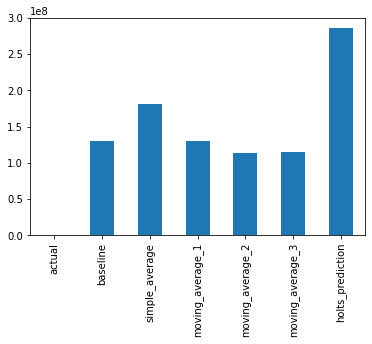

In [91]:
results.T.describe().loc["mean"].plot.bar()

It seems that actually the moving average is the best predictor for `total_high_density_value`. 

## Time Series Modeling Looking at `total_high_density_blgs`

In [93]:
# Going to need to create a loop, and create an average rmse score to see which one would be best

results = pd.DataFrame()
updates = 0
target_variable = "total_high_density_bldgs"
for i in unique_city_states:
    # read data and create dataframe
    df, kmeans = mo.prep_prediction_data()
    df["city_state"] = df.city + "_" + df.state
    modeling_df = df[df.city_state == i]
    
    # Create new dataframes
    modeling_df = modeling_df[["year", "city_state", target_variable]]
    modeling_df.year = pd.to_datetime(modeling_df.year, format = '%Y')
    modeling_df = modeling_df.set_index("year")
    # Split our data
    train = modeling_df[:"2015"]
    validate = modeling_df["2016":"2017"]
    test = modeling_df["2018":]
    # Model
    predictions = time_series_modeling.run_all_models(train, validate, target_variable, rolling_period = [1, 2, 3])
    # Evaluate
    rmse = predictions.apply(lambda col: sqrt(sklearn.metrics.mean_squared_error(predictions.actual, col)))
    rmse = pd.DataFrame(rmse, columns=[i])
    
    results = pd.concat([rmse, results], axis = 1)
    
results

,York_PA,Worcester_MA,Wilmington_NC,Washington_DC,Tuscaloosa_AL,Tulsa_OK,Tucson_AZ,Trenton_NJ,Toledo_OH,Tampa_FL,...,Birmingham_AL,Bellingham_WA,Baltimore_MD,Austin_TX,Atlanta_GA,Appleton_WI,Anchorage_AK,Allentown_PA,Albuquerque_NM,Albany_NY
actual,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
baseline,8.485281,9.192388,19.039433,25.504901,44.300113,16.446884,91.285267,7.810250,15.953056,29.334280,...,17.677670,10.511898,15.700318,77.162167,9.000000,29.706902,2.549510,14.142136,22.847319,76.105190
simple_average,7.536153,5.567666,19.134840,182.619109,27.060118,14.837062,69.144574,10.404326,15.716819,113.152898,...,27.602574,0.511957,49.494465,23.214842,120.835632,22.000191,2.168433,5.590027,11.066779,9.448471
moving_average_1,8.485281,9.192388,19.039433,25.504901,44.300113,16.446884,91.285267,7.810250,15.953056,29.334280,...,17.677670,10.511898,15.700318,77.162167,9.000000,29.706902,2.549510,14.142136,22.847319,76.105190
moving_average_2,6.708204,9.192388,14.534442,36.776351,33.889526,22.192341,77.500000,7.211103,8.500000,34.223530,...,15.116216,4.031129,14.089003,40.311289,16.224981,25.739075,1.581139,19.104973,21.476732,40.199502
moving_average_3,6.145641,9.192388,14.406210,27.098688,28.398944,18.659017,74.148829,7.603216,8.540427,27.333110,...,17.445885,0.528110,17.912535,110.443238,22.847319,20.471417,6.519202,14.468894,9.848858,24.005601
holts_prediction,75.129366,23.161389,55.920074,934.976331,78.805095,173.218055,79.648250,12.843118,96.553126,788.392969,...,27.019567,121.190397,733.479214,744.336786,357.702045,20.259458,91.172038,72.979388,54.343004,35.046559


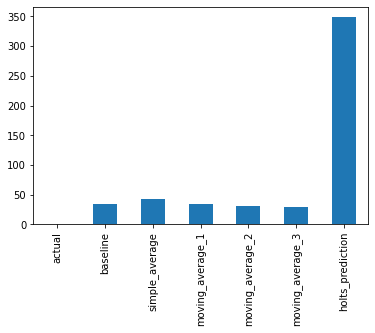

In [94]:
results.T.describe().loc["mean"].plot.bar()

Again - we see that the moving average is perhaps the overall best performance metric. It seems a rolling period of 2 is still the best.

## Time Series Modeling Looking at `total_high_density_units`

In [95]:
# Going to need to create a loop, and create an average rmse score to see which one would be best

results = pd.DataFrame()
updates = 0
target_variable = "total_high_density_units"
for i in unique_city_states:
    # read data and create dataframe
    df, kmeans = mo.prep_prediction_data()
    df["city_state"] = df.city + "_" + df.state
    modeling_df = df[df.city_state == i]
    
    # Create new dataframes
    modeling_df = modeling_df[["year", "city_state", target_variable]]
    modeling_df.year = pd.to_datetime(modeling_df.year, format = '%Y')
    modeling_df = modeling_df.set_index("year")
    # Split our data
    train = modeling_df[:"2015"]
    validate = modeling_df["2016":"2017"]
    test = modeling_df["2018":]
    # Model
    predictions = time_series_modeling.run_all_models(train, validate, target_variable, rolling_period = [1, 2, 3])
    # Evaluate
    rmse = predictions.apply(lambda col: sqrt(sklearn.metrics.mean_squared_error(predictions.actual, col)))
    rmse = pd.DataFrame(rmse, columns=[i])
    
    results = pd.concat([rmse, results], axis = 1)
    
results

,York_PA,Worcester_MA,Wilmington_NC,Washington_DC,Tuscaloosa_AL,Tulsa_OK,Tucson_AZ,Trenton_NJ,Toledo_OH,Tampa_FL,...,Birmingham_AL,Bellingham_WA,Baltimore_MD,Austin_TX,Atlanta_GA,Appleton_WI,Anchorage_AK,Allentown_PA,Albuquerque_NM,Albany_NY
actual,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
baseline,25.109759,167.757265,395.637460,2385.538199,517.187103,233.754144,978.995659,248.712686,100.531090,860.919567,...,1052.057508,39.629534,1263.901302,1276.935785,2328.148728,299.207286,64.124878,245.512729,199.981249,1113.775785
simple_average,87.768835,206.980246,313.796890,614.195180,288.515597,239.041570,793.481368,117.778487,306.799574,1490.636427,...,595.477197,76.255416,691.393565,3264.039093,2325.247621,206.582172,28.115990,104.309963,154.768258,301.481224
moving_average_1,25.109759,167.757265,395.637460,2385.538199,517.187103,233.754144,978.995659,248.712686,100.531090,860.919567,...,1052.057508,39.629534,1263.901302,1276.935785,2328.148728,299.207286,64.124878,245.512729,199.981249,1113.775785
moving_average_2,25.480385,230.179278,329.810931,1384.851075,239.518788,527.944126,799.760277,87.143560,143.788908,1151.729352,...,887.658155,30.536863,821.374610,1117.249413,2465.720686,228.048789,50.159745,409.507631,158.443207,473.154573
moving_average_3,36.333165,236.089260,311.237851,1587.571289,261.729324,389.760168,776.168782,147.952387,103.442442,1339.067026,...,757.271418,19.506409,886.607298,1174.342254,2550.032976,175.924896,97.412160,274.181398,205.243024,218.463956
holts_prediction,261.637036,159.753454,887.996232,1078.185596,503.750062,2180.232625,1161.321158,616.209637,1085.176381,7927.487055,...,885.032405,1719.310613,1202.391383,9794.359986,2152.504025,163.744089,468.304016,899.350104,427.864463,2635.332606


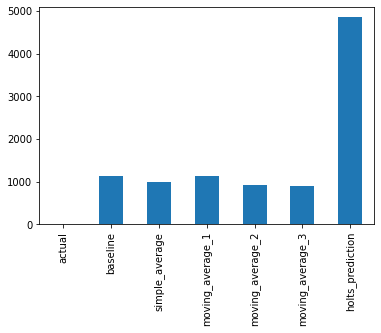

In [96]:
results.T.describe().loc["mean"].plot.bar()

In this case, it seems that the simply average and the moving_average performing fairly similarly.

## Using Facebook Prophet

In [141]:
train

,ei_x,cap,floor
ds,,,
1998-01-01,0.795989,3.165294,0.198714
1999-01-01,1.164195,3.165294,0.198714
2000-01-01,1.335546,3.165294,0.198714
2001-01-01,1.018631,3.165294,0.198714
2002-01-01,0.856185,3.165294,0.198714
2003-01-01,0.968583,3.165294,0.198714
2004-01-01,1.445231,3.165294,0.198714
2005-01-01,0.623998,3.165294,0.198714
2006-01-01,1.380533,3.165294,0.198714


In [157]:
target_variable = "ei_x"
# floor = train[target_variable].min() / 2
# cap = train[target_variable].max() * 2

In [158]:
train.drop(columns="city_state", inplace = True)

In [159]:
train.index.rename("ds", inplace=True)

In [160]:
train.rename(columns={"ei_x":"y"}, inplace=True)

In [164]:
train = train.reset_index()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


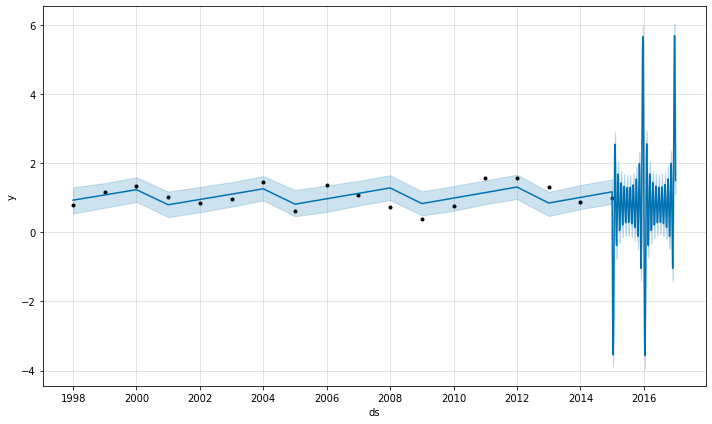

In [166]:
# Python

m = Prophet(seasonality_mode='multiplicative').fit(train)
future = m.make_future_dataframe(periods=730)
fcst = m.predict(future)
fig = m.plot(fcst)

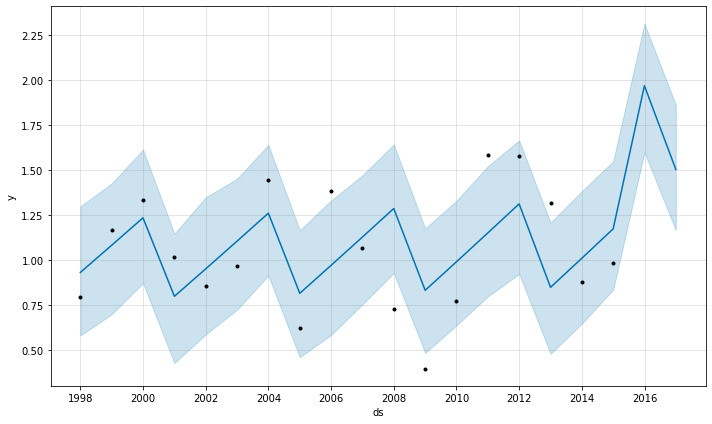

In [167]:
future = m.make_future_dataframe(periods=2, freq='Y')
fcst = m.predict(future)
fig = m.plot(fcst)

## Conclusion

It seems that simple average is the best method to calculate the evolution index, while rolling average, with a period of 2, is the best features for predicting total high density. 

Suggested plan moving forward:

1. Use simple average to calculate evolution index
1. Use rolling avereage to calculate all other values.